# Strategy creation workflow

In [29]:
import time
import math
import datetime
from IPython.display import display, clear_output
import connect as ibc
import asyncio
import pandas as pd
from ib_insync import *

import numpy as np
util.startLoop()  # uncomment this line when in a notebook

## Establish connection to IB

In [6]:
ib = IB()
ib.connect('127.0.0.1', 7497, clientId=1)

<IB connected to 127.0.0.1:7497 clientId=1>

## Download the last ticks and create a dataframe

In [8]:
contract = Forex('EURUSD')
ib.qualifyContracts(contract)

In [22]:
detail = ib.reqContractDetails(contract)
print('Minimum Tick increment possible =',detail[0].minTick)

Minimum Tick increment possible = 5e-05


In [31]:
def round_down(x, a):
    return round(round(x / a) * a, -int(math.floor(math.log10(a))))

In [32]:
round_down(1.25892, 0.00005)

1.2589

In [9]:
start = ''
end = datetime.datetime.now()
ticks = ib.reqHistoricalTicks(contract, start, end, 1000, 'BID_ASK', useRth=False)

In [5]:
df = []

In [6]:
for tick in ticks:
    df.append([tick.time, tick.sizeBid, tick.priceBid, tick.priceAsk, tick.sizeAsk])

In [8]:
df = pd.DataFrame(df)
df.columns = ['time', 'bidSize', 'bid', 'ask', 'askSize']

<AxesSubplot:>

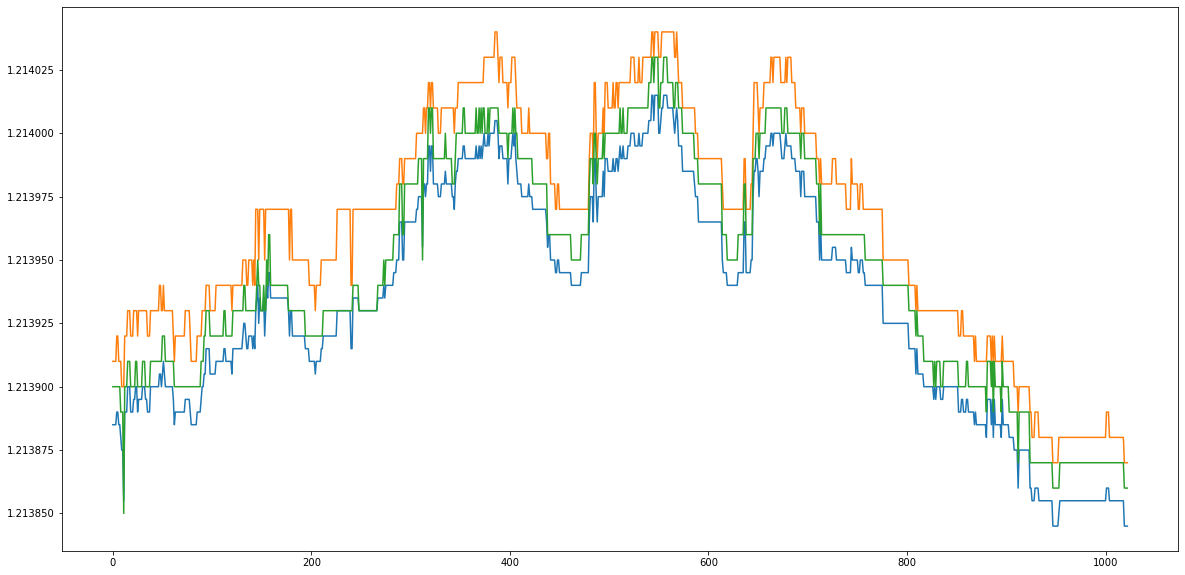

In [56]:
df['mid'] = (df.ask + df.bid) / 2
(df.mid-0.00002).plot(figsize=(20,10))
df.ask.plot()
df.bid.plot()

## Create a Strategy and Backtest it 

In [75]:
def backtest(temp):
    """
    Long-only backtesting function. The values and decisions need to be changed 
    while designing your own strategy (such as thres, row['YOUR INDICATOR'], etc.).

    :param temp: pd.dataframe containing the columns mentioned.
    """
    
    long = False
    
    trades = 0
    thres = 0.7

    amount = 1    
    long_price = None
    ret = []
    
    for index, row in temp.iterrows():
        
        if row['ratio_ma'] > thres and not long:
            
            print('Long {} {} '.format(row['ask'], row['spread']))
            trades += 1
            long = True
            long_price = row['ask']            
            ret.append(0)            
            
        elif long and row['ratio_ma'] < (0.5):

            print('Close Long {} {}'.format(row['bid'], row['spread']))
            long = False
            long_ret = ((100 / long_price * row['bid']) - 100) / 100 * amount
            ret.append(long_ret)    
            lvl = 0            
            
        elif long:

            long_ret = ((100 / long_price * row['bid']) - 100) / 100 * amount
            long_price = row['bid']
            ret.append(long_ret)
            
        else:
            ret.append(0)

    temp['returns'] = ret
    temp['cum_returns'] = (1+temp.returns).cumprod()
    
    print(trades, 'trades were made')
    print('backtest finished')
    return temp

In [76]:
ret = backtest(df)

Long 1.21134 2.0000000000131024e-05 
Close Long 1.21135 1.0000000000065512e-05
Long 1.21134 2.999999999997449e-05 
2 trades were made
backtest finished


<AxesSubplot:>

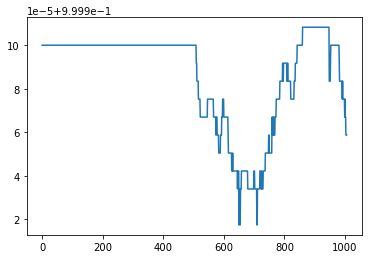

In [77]:
ret.cum_returns.plot()

In [129]:
df['ratio'] = (df.bidSize / (df.askSize+df.bidSize))
df['spread'] = df.ask - df.bid
df['bid_lagged'] = df.bid.shift(50)
df['ratio_ma'] = df.ratio.rolling(100).mean()

<AxesSubplot:label='d99574a7-4d93-47e7-80ac-43bf69c36fc9'>

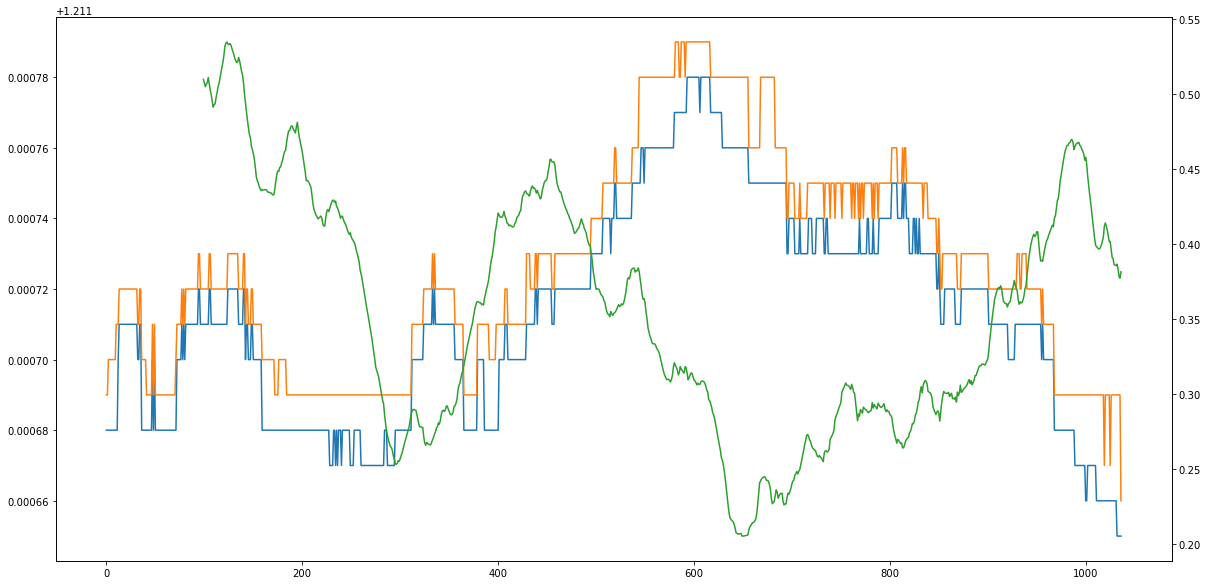

In [131]:
df.bid.plot(figsize=(20,10))
df.ask.plot()
#df.bid.shift(50).plot()
df.ratio_ma.plot(secondary_y=True)

## Disconnect from IB

In [23]:
ib.disconnect()